# Criando Segmentos de Cliente  

#### Udacity - Nanodegree Engenheiro de Machine Learning - Aprendizagem Não Supervisionada


## Visão geral do projeto

Neste projeto, irei analisar o conjunto de dados de montantes de despesas anuais de vários clientes (reportados em *unidades monetárias*), coletados de clientes de uma distribuidora atacadista em Lisboa, para identificar segmentos de clientes ocultos nos dados. Primeiro, irei explorar os dados selecionando um pequeno subconjunto como amostra e determinar se alguma das categorias de produtos está altamente correlacionada com outra. Depois, pré-processarei os dados, dimensionando cada categoria de produto e identificando (e removendo) valores aberrantes. De posse dos dados "limpos", aplicarei PCA a eles e implementarei os algoritmos de clustering para criar os segmentos. Por último, irei comparar a segmentação encontrada com uma marcação adicional, afim de dar ao distribuidor discernimento sobre como melhor estruturar seu serviço de entrega de acordo com as necessidades de cada cliente.

O conjunto de dados deste projeto pode ser encontrado no [Repositório de Machine Learning da UCI](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers). Para efeitos de projeto, os atributos `'Channel'` e `'Region'` serão excluídos da análise – que focará então nas seis categorias de produtos registrados para clientes.

In [1]:
import pyforest as py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
from IPython.display import display # Permite o uso de display() para DataFrames
from plotly.offline import iplot
from plotly.graph_objs import Scatter
py.init_notebook_mode(connected=True)

# Bibliotecas do sklearn para plotagens e análise com machine learning 
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score

# Importa o código sumplementar para visualização de visuals.py 

import visuals as vs

# Mostra matplotlib no corpo do texto (bem formatado no Notebook) 

%matplotlib inline

# Desabilitando Avisos comuns desnecessários
if not sys.warnoptions:
    import warnings
    warnings.simplefilter('ignore')
    warnings.simplefilter(action='ignore', category=FutureWarning) 


# Carrega o conjunto de dados dos clientes da distribuidora de atacado
try:
    data = pd.read_csv("base/customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print("O conjunto de dados da Wholesale possui {} amostras com {} features cada.".format(*data.shape))
except:
    print("O conjunto de dados não pôde ser carregado.")

<IPython.core.display.Javascript object>

O conjunto de dados da Wholesale possui 440 amostras com 6 features cada.


## Explorando os Dados
Nesta seção, irei começa a explorar os dados através de visualizações e códigos para entender como cada atributo é relacionado a outros. Irei observar descrições estatísticas do conjunto de dados, considerando a relevância de cada atributo, e selecionando alguns exemplos de pontos de dados que serão utilizados no decorrer do curso do projeto.

O bloco de código abaixo demonstra as descrições estatísticas sobre o conjunto de dados. Note que o conjunto é compostos de seis categorias importantes de produtos: **'Fresh'**, **'Milk'**, **'Grocery'**, **'Frozen'**, **'Detergents_Paper'** e **'Delicatessen'** (Perecíveis, Lacticínios, Secos e Molhados, Congelados, Limpeza/Higiene, Padaria/Frios).

In [2]:
# Mostra a descrição do conjunto de dados
display(data.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### Implementação: Selecionando Amostras

Para melhor compreensão da clientela, será selecionado algumas amostras para serem exploradas com mais detalhes.

In [3]:
# Seleciona três índices como amostra do conjunto de dados
indices = [0, 229, 431]

# Cria um DataFrame das amostras escolhidas
samples_plot  = pd.DataFrame(data.loc[indices], columns = data.keys())
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print( "Chosen samples of wholesale customers dataset:")
display(samples)

Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,12669,9656,7561,214,2674,1338
1,8656,2746,2501,6845,694,980
2,8533,5506,5160,13486,1377,1498


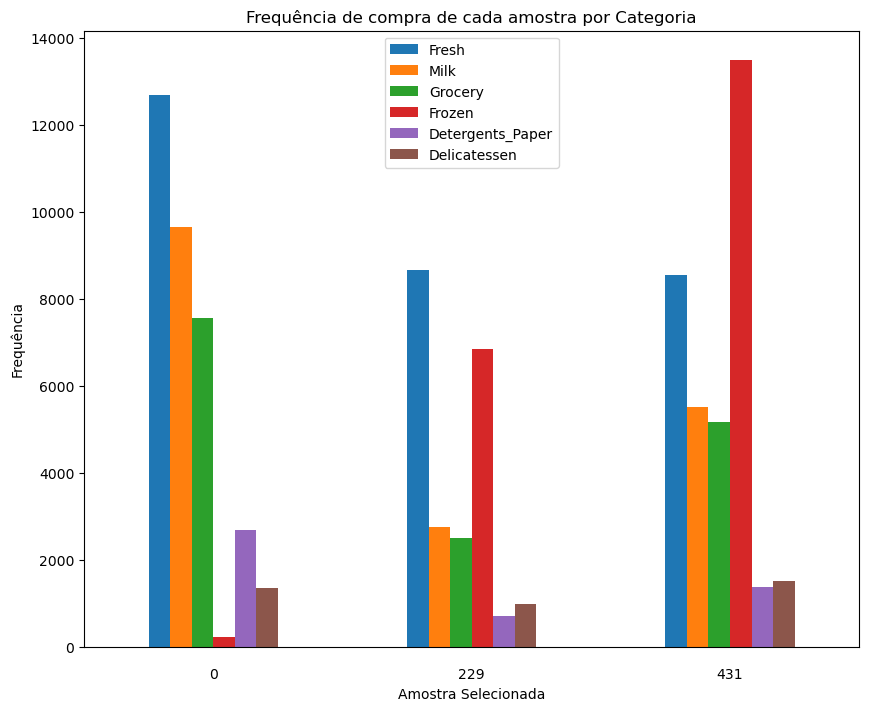

In [4]:
samples_plot.plot(kind="bar", figsize = (10, 8))
ax = plt.gca()
ax.tick_params(axis = 'x', which = 'major', pad = 15, size = 0)
ax.set_title('Frequência de compra de cada amostra por Categoria')
ax.set_xlabel('Amostra Selecionada')
ax.set_ylabel('Frequência')
plt.setp(ax.get_xticklabels(), rotation = 0)
plt.show()

#### Categorias:

   - **Fresh**:  Perecíveis
   - **Milk**: Lacticínios 
   - **Grocery**: Secos e Molhados
   - **Frozen**: Congelados 
   - **Detergents_Paper**: Limpeza/Higiene 
   - **Delicatessen**: Padaria/Frios 

Levando em consideração as visualizações acima, posso fazer as seguintes suposições:

**Amostra do índice 0**

A primeira amostra selecionada apresenta uma grande quantidade de produtos perecíveis, laticínios, secos e molhados, por outro lado, apresenta uma baixa quantidade de produtos congelados, valores razoáveis para produtos de limpeza/higiene e padaria/frios.
Acredito que seja uma quitanda dessas que vende um pouco de tudo, mas com foco maior em frutas/verduras, laticínios e secos/molhados.

**Amostra do índice 229**

A amostra apresenta uma grande quantidade de produtos perecíveis e de produtos congelados, por outro lado, existe um equilíbrio entre lacticínios e secos/molhados que vem logo após os citados anteriormente. Produtos de Limpeza/hiegiene apresenta uma pequena quantidade, que podemos supor ser de uso interno do estabelecimento. Produtos de padaria/frios apresenta uma quantidade razoável.
Acredito que seja um estabelecimento que serve saladas e alimentos de preparo rápidos, devido a quantidade de congelados.

**Amostra do índice 431**

A amostra apresenta grandes quantidades de perecíveis, lacticínios, secos/molhados e congelados. Devido ao "equilíbrio" entre as categorias citadas anteriormente, acredito que seja um pequeno mercado, com foco em congelados.  

### Relevância do Atributo

Um pensamento interessante a se considerar é se um (ou mais) das seis categorias de produto são na verdade relevantes para entender a compra do cliente. Dito isso, é possível determinar se o cliente que comprou certa quantidade de uma categoria de produto vai necessariamente comprar outra quantidade proporcional de outra categoria de produtos. Para isso, irei treinar uma DecisionTreeRegressor removendo uma feature a cada iteração e pontuar quão bem o modelo pode prever o atributo removido.

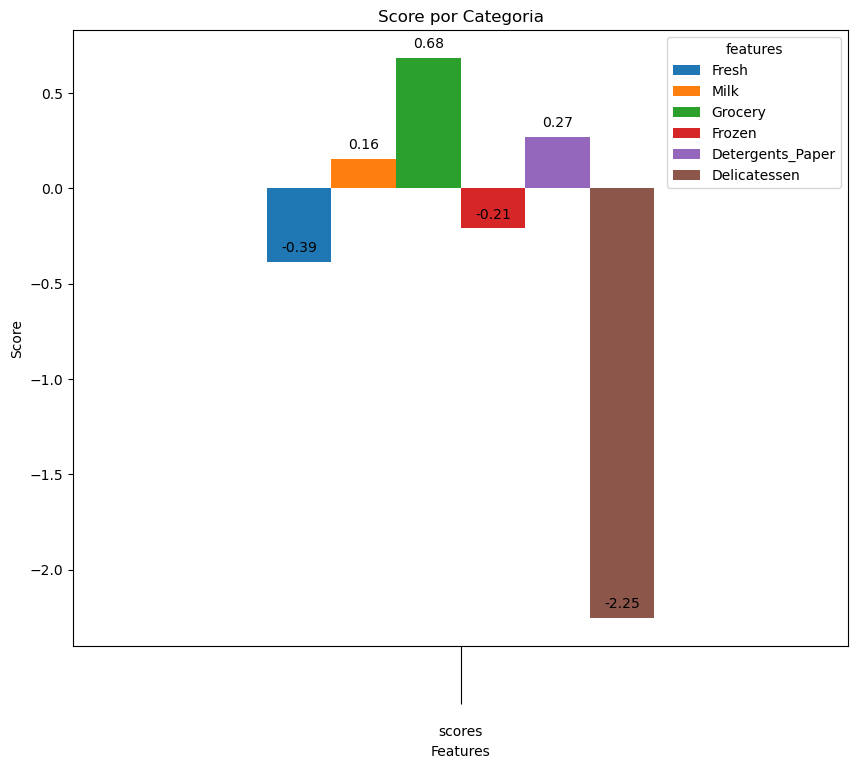

In [5]:

# Criando uma lista com o nome das features do dataset
features = list(data.columns.values)
raw_data = []
for feature in features:
    # salvando o atributo que será removido
    target = data[feature]
    # Fazer uma cópia do DataFrame utilizando a função 'drop' para soltar o atributo dado
    new_data = data.drop([feature],axis = 1)
    # Dividir os dados em conjuntos de treinamento e teste utilizando o atributo dado como o alvo
    X_train, X_test, y_train, y_test = train_test_split(new_data, target, test_size = 0.25, random_state = 42)
    # Criando um árvore de decisão regressora
    regressor = DecisionTreeRegressor(random_state = 42)
    #ajustando ao conjunto de treinamento
    regressor.fit(X_train, y_train)
    # Reportar a pontuação da previsão utilizando o conjunto de teste
    raw_data.append(regressor.score(X_test, y_test))

# Criando um dataframe com 2 coluanas(features e scores) e depois obtendo a matriz transposta para
# para transformar os valores de features em colunas    
scores_features = pd.DataFrame({'features' : features, 'scores' : raw_data}).set_index('features').T

# Plotando os scores encontrados para facilitar o entendimento.
scores_features.plot(kind="bar", figsize = (10, 8))
ax = plt.gca()
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2.,
                                          p.get_height()), ha='center',
                va='center', xytext=(0, 10), textcoords='offset points')
ax.tick_params(axis = 'x', which = 'major', pad = 15, size = 42)
ax.set_title('Score por Categoria')
ax.set_ylabel('Score')
ax.set_xlabel('Features')
plt.setp(ax.get_xticklabels(), rotation = 0)
plt.show()

> Sabemos que o coeficiente de determinação, `R^2`, é pontuado entre 0 e 1, sendo 1 o ajuste perfeito. Um `R^2` negativo indica que o modelo falhou em ajustar os dados. Se você obter um score baixo para um atributo em particular, isso nos faz acreditar que aquele ponto de atributo é difícil de ser previsto utilizando outros atributos, sendo assim um atributo importante quando considerarmos a relevância.

Como podemos perceber na visualização acima, eu achei necessário calcular o score de todas as features, a fim de tentar prever melhor os hábitos de compras dos clientes. De acordo com os scores calculados, encontramos valores negativos para Fresh, Frozen e Delicatessen, o que indica que a DecisionTreeRegressor falhou em ajustar os dados. Por outro lado, encontramos valores positivos para Milk, Grocery e Detergents_Paper. Grocery obteve o maior score com 0.68, que significa que é uma feature de fácil previsão, mas para identificar habitos de compras precisamos de features que não sejam de fácil previsão, dessa forma, acredito que Milk e Detergents_Paper irá me ajudar com este trabalho. 

### Visualizando a Distribuição de Atributos
Para entender melhor o conjunto de dados, irei construir uma matriz de dispersão de cada um dos seis atributos dos produtos presentes nos dados.

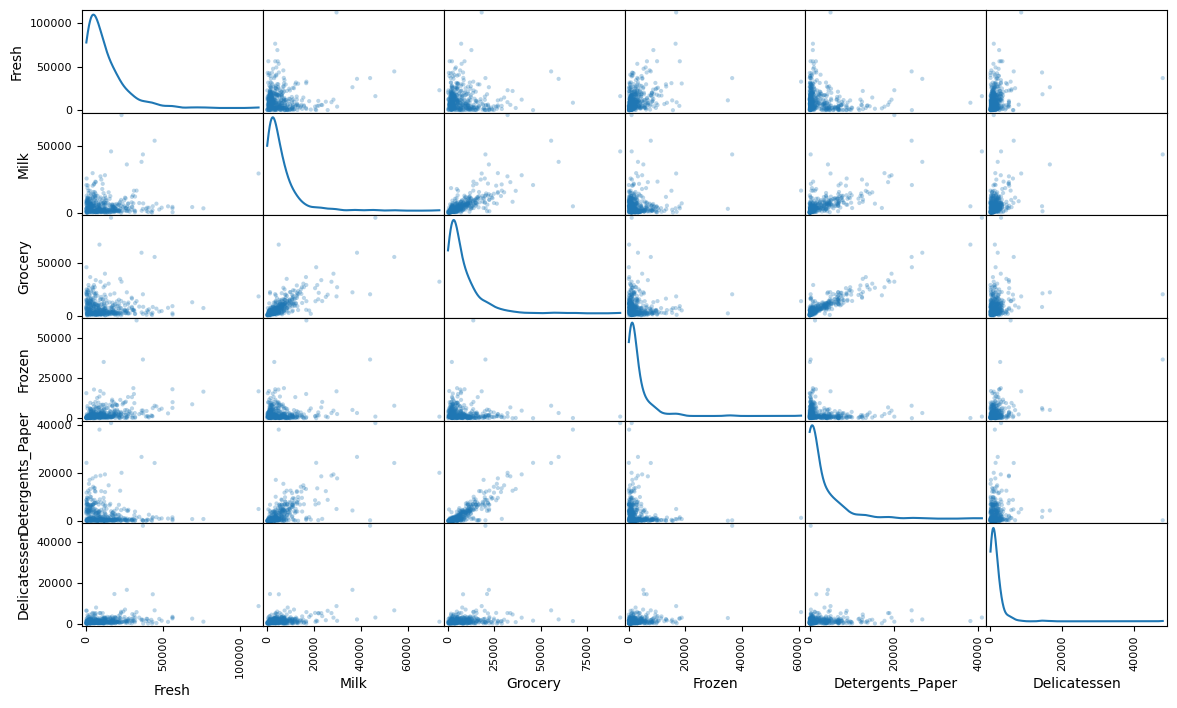

In [6]:
# Produza uma matriz de dispersão para cada um dos pares de atributos dos dados
pd.plotting.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

Com base na matriz de dispersão acima, podemos perceber que existe uma grande quantidade de pontos próximo a 0, o que da para supor que as distribuições são assimétricas positivas, fato que foi devidamente comprovado com a visualização abaixo:

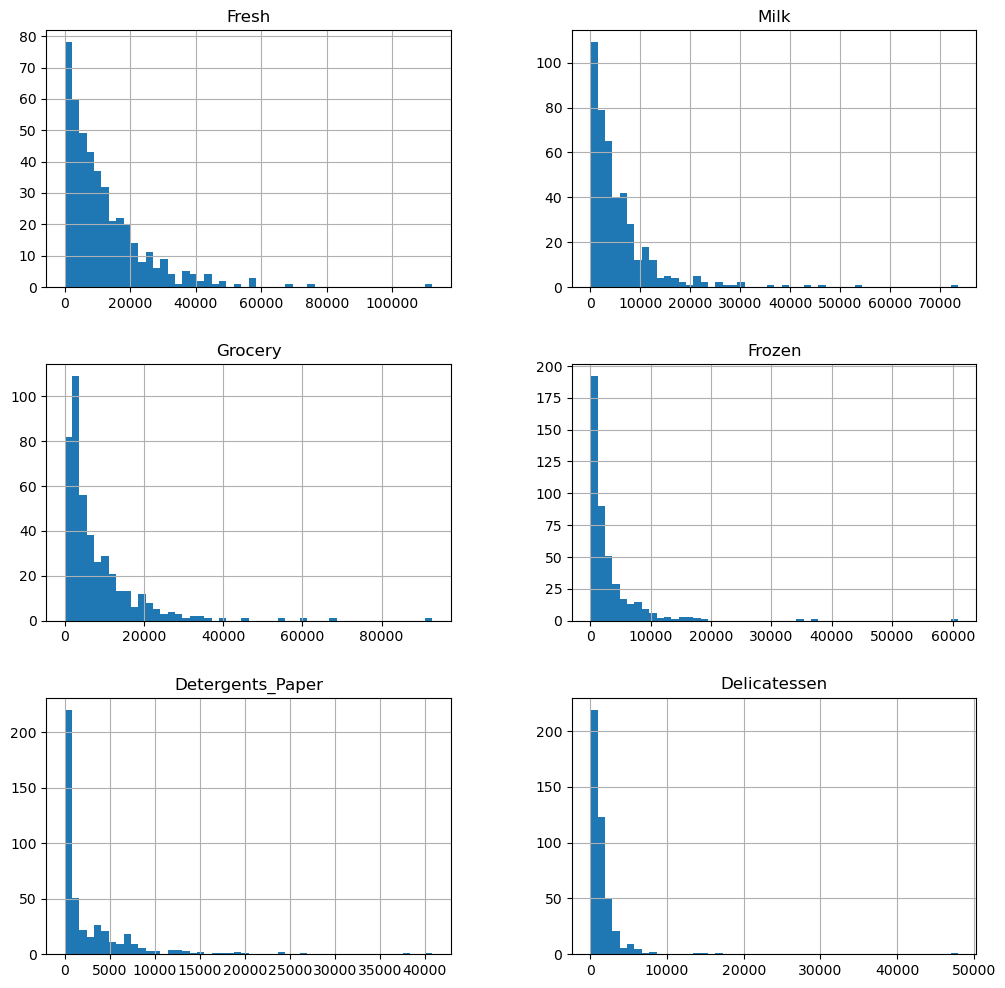

In [7]:
data.hist(bins = 50, figsize = (12, 12))
plt.show()

Outro ponto a ser notado na matriz é a presença de diversos outliers. Eu acreditava que os scores negativos em Fresh, Frozen e Delicatessen estariam sendo influênciados por outliers, mas analisando a visualização abaixo, somente a presença de outliers não poderia causar os scores negativos, já que todos as features apresentam uma quantidade de outliers significantes.

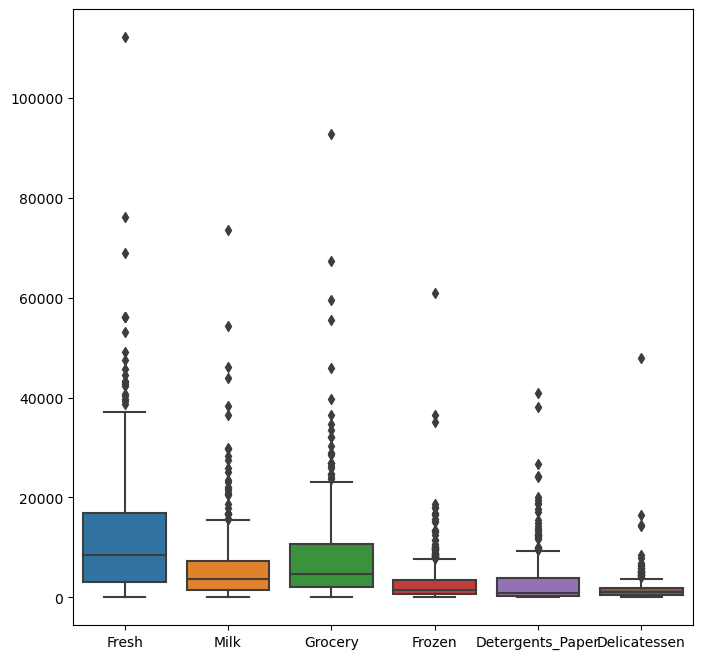

In [8]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.boxplot(data=data)
plt.show()

É possível detectar uma correlação entre Grocery e Detergents_Paper na matriz de dispersão, isso deve ser o motivo das duas features terem recebido os maiores scores para previsão. Podemos perceber melhor o relacionamento entre elas, visualizando o gráfico de dispersão abaixo, onde os quadrados residuais do modelo são pequenos( isto é, as distâncias entre os pontos verticais do conjunto de dados e a linha reta). A matriz de correlação nos mostra em números, que existe uma correlação quase perfeita entre Grocery e Detergents_Paper com 0.92 e correlação forte entre Grocery e Milk com 0.73

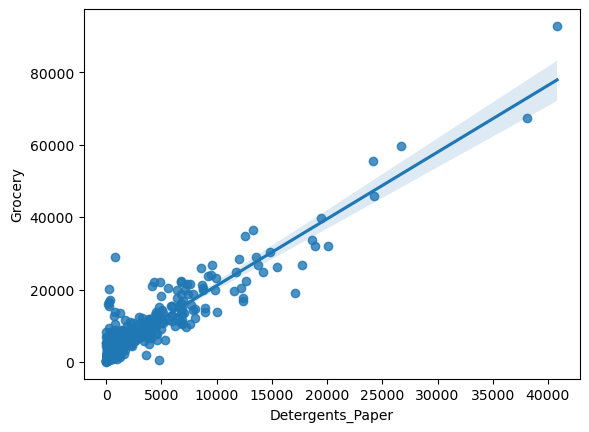

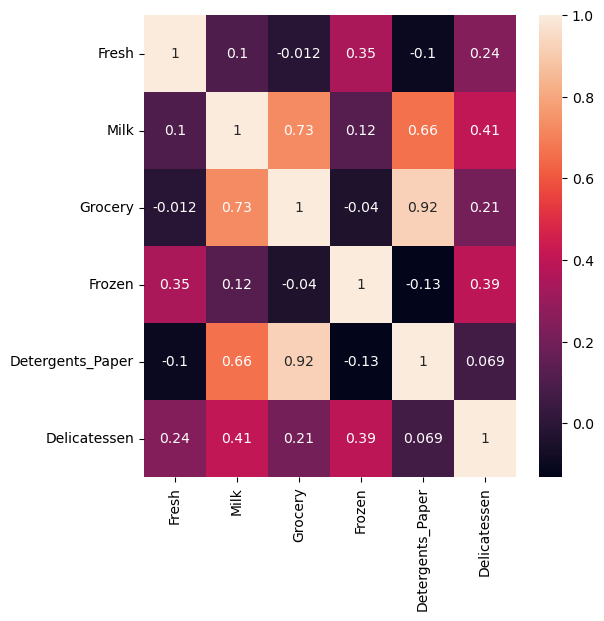

In [9]:
sns.regplot(x = "Detergents_Paper", y = "Grocery", data = data)
plt.show()

fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(data.corr(), annot=True)
plt.show()

## Pré-processamento de Dados
Nesta seção, irei pré-processar os dados para criar uma melhor representação dos clientes ao executar um escalonamento dos dados. Pré-processar os dados é geralmente um passo fundamental para assegurar que os resultados obtidos na análise são importantes e significativos.

### Implementação: Escalonando Atributos
Se os dados não são distribuídos normalmente, especialmente se a média e a mediana variam significativamente (indicando um grande desvio), é quase sempre [apropriado] ](http://econbrowser.com/archives/2014/02/use-of-logarithms-in-economics) aplicar um escalonamento não linear – particularmente para dados financeiros. Uma maneira de conseguir escalonar dessa forma é utilizando o [ teste Box-Cox](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html), que calcula o melhor poder de transformação dos dados, que reduzem o desvio. Uma abordagem simplificada que pode funcionar na maioria dos casos seria aplicar o algoritmo natural.


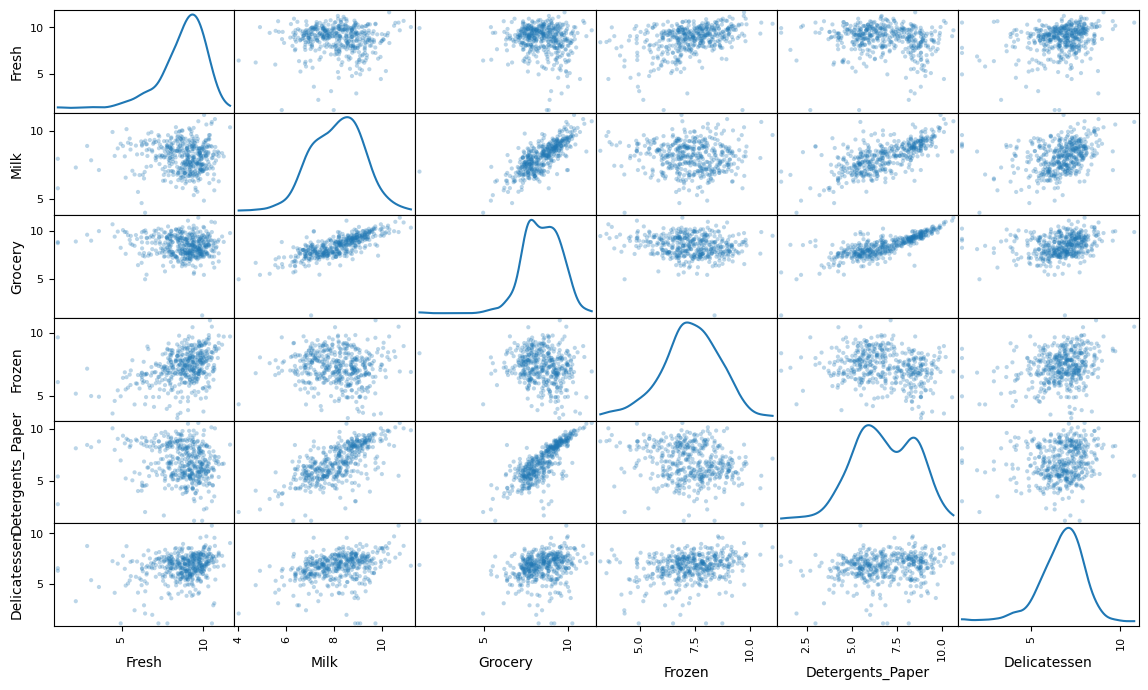

In [10]:
# Escalona os dados utilizando o algoritmo natural
log_data = np.log(data)

# Escalona a amostra de dados utilizando o algoritmo natural
log_samples = np.log(samples)

# Produz uma matriz de dispersão para cada par de atributos novos-transformados
pd.plotting.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Observação
Após aplicar o algoritmo natural para o escalonamento dos dados, a distribuição para cada atributo deve parecer mais normalizado. Para muitos pares de atributos, você vai precisar identificar anteriormente como sendo correlacionados, observe aqui se essa correlação ainda está presente (e se está mais forte ou mais fraca que antes).

O código abaixo mostra como a amostra de dados mudou depois do algoritmo natural ter sido aplicado a ela.

In [11]:
# Mostra a amostra dados log-transformada
display(log_samples)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,9.446913,9.175335,8.930759,5.365976,7.891331,7.198931
1,9.066008,7.917901,7.824446,8.831274,6.542472,6.887553
2,9.051696,8.613594,8.548692,9.509407,7.227662,7.311886


### Implementação: Detecção de valores atípicos (_Outlier_)
Identificar dados discrepantes é extremamente importante no passo de pré-processamento de dados de qualquer análise. A presença de valores discrepantes podem enviesar resultados que levam em consideração os pontos de dados. Há muitas "regras básicas" que constituem um valor discrepante em um conjunto de dados. Aqui usarei [o Método Turco para identificar valores atípicos](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): *O valor discrepante* é calculado 1,5 vezes a variação interquartil (IQR). Um ponto de dados com um atributo que está além de um passo de um valor discrepante do IQR para aquele atributo, ele é considerado anormal.

In [12]:
# Para cada atributo encontre os pontos de dados com máximos valores altos e baixos
for feature in log_data.keys():
    
    # Calcula Q1 (25º percentil dos dados) para o atributo dado
    Q1 = np.percentile(log_data[feature], 25)
    
    # Calcula Q3 (75º percentil dos dados) para o atributo dado
    Q3 = np.percentile(log_data[feature], 75)
    
    # Utiliza a amplitude interquartil para calcular o passo do discrepante (1,5 vezes a variação interquartil)
    step = (Q3 - Q1) * 1.5
    
    # Mostra os discrepantes
    print( "Data points considered outliers for the feature '{}':".format(feature))
    display(log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))])
    
# índices dos pontos de dados que serão removidos
outliers  = [65, 66, 75, 128, 15]

# Remove os outliers, caso nenhum tenha sido especificado
good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)

Data points considered outliers for the feature 'Fresh':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
81,5.389072,9.163249,9.575192,5.645447,8.964184,5.049856
95,1.098612,7.979339,8.740657,6.086775,5.407172,6.563856
96,3.135494,7.869402,9.001839,4.976734,8.262043,5.379897
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
171,5.298317,10.160530,9.894245,6.478510,9.079434,8.740337
193,5.192957,8.156223,9.917982,6.865891,8.633731,6.501290
218,2.890372,8.923191,9.629380,7.158514,8.475746,8.759669
304,5.081404,8.917311,10.117510,6.424869,9.374413,7.787382


Data points considered outliers for the feature 'Milk':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
86,10.039983,11.205013,10.377047,6.894670,9.906981,6.805723
98,6.220590,4.718499,6.656727,6.796824,4.025352,4.882802
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
356,10.029503,4.897840,5.384495,8.057377,2.197225,6.306275


Data points considered outliers for the feature 'Grocery':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442


Data points considered outliers for the feature 'Frozen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
38,8.431853,9.663261,9.723703,3.496508,8.847360,6.070738
57,8.597297,9.203618,9.257892,3.637586,8.932213,7.156177
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
145,10.000569,9.034080,10.457143,3.737670,9.440738,8.396155
175,7.759187,8.967632,9.382106,3.951244,8.341887,7.436617
264,6.978214,9.177714,9.645041,4.110874,8.696176,7.142827
325,10.395650,9.728181,9.519735,11.016479,7.148346,8.632128
420,8.402007,8.569026,9.490015,3.218876,8.827321,7.239215
429,9.060331,7.467371,8.183118,3.850148,4.430817,7.824446
439,7.932721,7.437206,7.828038,4.174387,6.167516,3.951244


Data points considered outliers for the feature 'Detergents_Paper':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
161,9.428190,6.291569,5.645447,6.995766,1.098612,7.711101


Data points considered outliers for the feature 'Delicatessen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
109,7.248504,9.724899,10.274568,6.511745,6.728629,1.098612
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
137,8.034955,8.997147,9.021840,6.493754,6.580639,3.583519
142,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
183,10.514529,10.690808,9.911952,10.505999,5.476464,10.777768
184,5.789960,6.822197,8.457443,4.304065,5.811141,2.397895
187,7.798933,8.987447,9.192075,8.743372,8.148735,1.098612
203,6.368187,6.529419,7.703459,6.150603,6.860664,2.890372


Existem 5 pontos de dados considerados outliers(65, 66, 75, 128, 154) que se repetem em cada feature e precisam ser removidos, porque pretendemos trabalhar com PCA e o mesmo é sensível a outliers.

## Transformação de Atributo
Nesta seção, irei utilizar a análise de componentes principais (PCA) para elaborar conclusões sobre a estrutura subjacente de dados de clientes do atacado. Dado que ao utilizar a PCA em conjunto de dados calcula as dimensões que melhor maximizam a variância, irei encontrar quais combinações de componentes de atributos melhor descrevem os consumidores.

### PCA

Agora que os dados foram escalonados em uma distribuição normal e qualquer discrepante necessário foi removido, irei aplicar PCA na `good_data` para descobrir qual dimensão dos dados melhor maximizam a variância dos atributos envolvidos. Além de descobrir essas dimensões, a PCA também irá reportar a *razão da variância explicada* de cada dimensão – quanta variância dentro dos dados é explicada pela dimensão sozinha. Note que o componente (dimensão) da PCA pode ser considerado como um novo "feature" do espaço, entretanto, ele é uma composição do atributo original presente nos dados.

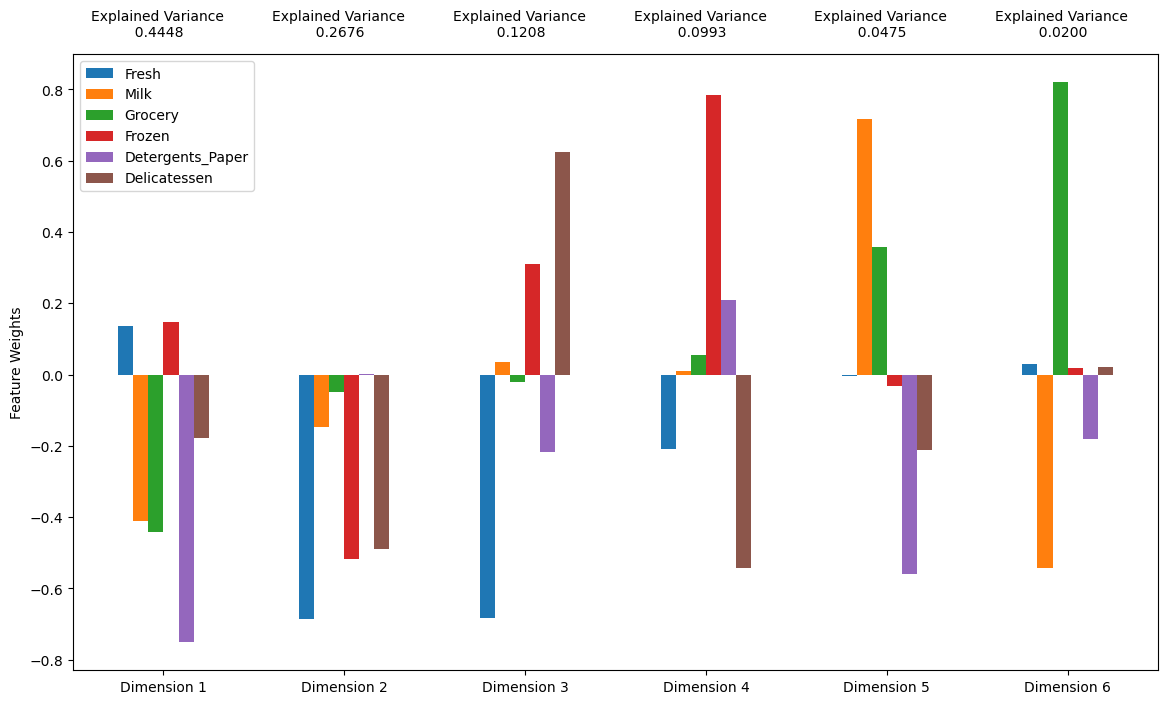

In [13]:
# Aplica a PCA ao ajustar os bons dados com o mesmo número de dimensões como atributos
from sklearn.decomposition import PCA
pca = PCA(n_components = 6).fit(good_data)

# Transforma a amostra de data-log utilizando o ajuste da PCA acima
pca_samples = pca.transform(log_samples)

# Gera o plot dos resultados da PCA
pca_results = vs.pca_results(good_data, pca)

A 1º e a 2º dimensão juntas apresentam 0.71% de variância, incluindo a 3º e a 4º dimensão chegamos a 93,25% de variância.

Analisando o gráfico acima, podemos perceber que as dimensões representam diferentes padrões de consumo, sendo assim, não é possível definir uma dimensão que melhor represente o consumo dos clientes.

- **1º Dimensão:** Essa dimensão caracteriza-se pela maior variância(44%) e existem 2 pesos positivos(Frozen e Fresh) e 4 negativos(Detegents_Paper, Milk, Grocery e Delicatessen). Na medida que cai a compra de Detegents_Paper, Milk, Grocery e Delicatessen, aumenta a compra de Frozen e Fresh.
- **2º Dimensão:** Essa dimensão apresenta pesos negativos em quase todas as features, com exceção de Detergents_Paper que não aparece na visualização.
- **3º Dimensão:** Os clientes dessa dimensão compram mais Delicatessen, Frozen e Milk, no entanto estão evitando comprar Fresh e Detergents_Paper. 
- **4º Dimensão:** Essa dimensão tem quatro pesos positivos com uma maior predominância de Frozen, em contrapartida os clientes vem evitando comprar Delicatessen e Fresh.

### Observação
O código abaixo mostra como a amostra de log transformado mudou depois de receber a transformação da PCA aplicada a ele em seis dimensões.

In [14]:
# Exibe a amostra de log-data depois de aplicada a tranformação da PCA
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
0,-1.7601,0.1085,-0.9661,-1.6892,0.2608,-0.3865
1,0.7734,-1.0279,0.4439,0.9237,-0.3259,-0.3176
2,-0.3247,-1.7130,0.7879,1.4165,-0.0636,-0.2040


### Implementação: Redução da Dimensionalidade
Ao utilizar um componente principal de análise, um dos objetivos principais é reduzir a dimensionalidade dos dados – na realidade, reduzindo a complexidade do problema. Redução de dimensionalidade tem um custo: Poucas dimensões utilizadas implicam em menor variância total dos dados que estão sendo explicados. Por causo disso, a *taxa de variância explicada cumulativa* é extremamente importante para saber como várias dimensões são necessárias para o problema. Além disso, se uma quantidade significativa de variância é explicada por apenas duas ou três dimensões, os dados reduzidos podem ser visualizados depois.

In [15]:
# Aplica o PCA ao ajusta os bons dados com apenas duas dimensões
pca = PCA(n_components = 2).fit(good_data)

# Transforma os bons dados utilizando o ajuste do PCA acima
reduced_data = pca.transform(good_data)

# Transforma a amostra de log-data utilizando o ajuste de PCA acima
pca_samples = pca.transform(log_samples)

# Cria o DataFrame para os dados reduzidos
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

### Observação
O código abaixo mostra como a amostra de dados do log-transformado mudou depois de receber a transformação do PCA aplicada a ele em apenas duas dimensões. Percebe-se como os valores das duas primeiras dimensões permanessem constantes quando comparados com a transformação do PCA em seis dimensões.

In [16]:
# Exibe a amostra de log-data depois de aplicada a transformação da PCA em duas dimensões
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,-1.7601,0.1085
1,0.7734,-1.0279
2,-0.3247,-1.7130


## Visualizando um Biplot
Um biplot é um gráfico de dispersão onde cada ponto é representado por sua pontuação junto das componentes principais. Os eixos são as componentes principais (nesse caso, `Dimension 1` e `Dimenson 2`). Além disso, o biplot mostra a projeção dos atributos originais junto das componentes. Um biplot pode nos ajudar a interpretar a redução da dimensionalidade dos dados e descobrir relacionamentos entre as componentes principais e os atributos originais.

<Axes: title={'center': 'PC plane with original feature projections.'}, xlabel='Dimension 1', ylabel='Dimension 2'>

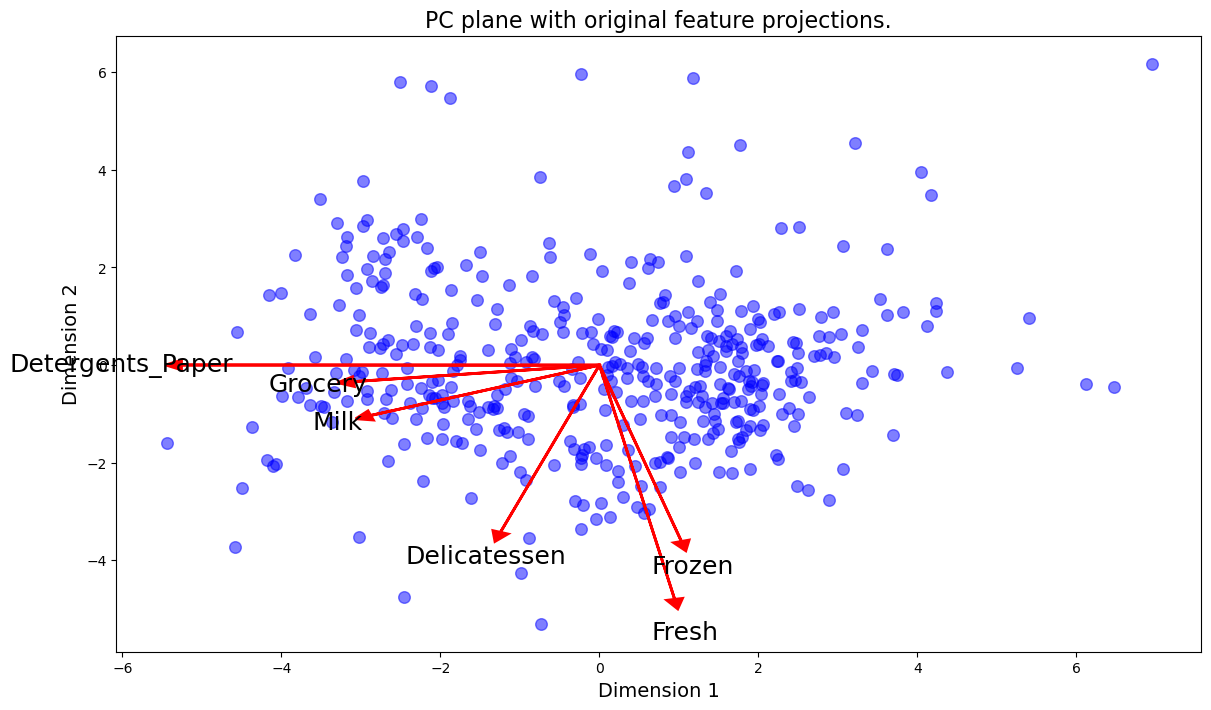

In [17]:
vs.biplot(good_data, reduced_data, pca)

## Clustering

Para criar o cluster, precisarei escolher utilizar o algoritmo de clustering K-Means ou o algoritmo de clustering do Modelo de Mistura Gaussiano para identificar as várias segmentações de clientes escondidos nos dados. Dessa forma, logo abaixo será apresentado os pontos fortes e fracos de cada modelo.

### K-Means 

O k-means é utilizado para criar clusters onde os pontos dentro do cluster são semelhantes. 

**Vantagens:**
- Os clusters têm densidade semelhante;
- Fácil de implementar
- Com um número grande de variáveis, K-means pode ser computacionalmente mais rápido que o cluster hierárquico.
- Produz clusters mais apertados do que o  clustering hierárquico,  especialmente se os clusters forem globulares.
- Uma instância pode alterar o cluster (mover para outro cluster) quando os centroides são recalculados.
**Desvantagens:**
- Difícil de prever o número de clusters (valor K).
- Os seeds iniciais têm um forte impacto nos resultados finais.
- A ordem dos dados tem um impacto nos resultados finais.
- Sensível à escala: redimensionar seus conjuntos de dados (normalização ou padronização) mudará completamente os resultados.

### Gaussian Mixture Model

O Gaussian Mixture Model Classifier (GMM) é um algoritmo de classificação de aprendizado supervisionado, que pode ser usado para classificar uma ampla variedade de sinais N-dimensionais.

**Vantagens:**
- São mais flexíveis em termos de covariância;
- Pode ser utilizados em dados que não são esféricos;
- Flexibilidade na escolha da distribuição de componentes;
- Obter uma estimativa de densidade para cada cluster;
- Uma classificação “soft” está disponível.
    
**Desvantagens:**
- A principal limitação do algoritmo GMM é que, por razões computacionais, ele pode deixar de funcionar se a dimensionalidade do problema for muito alta (isto é, maior que 6 dimensões, por exemplo). Se esse for o caso com seus dados, talvez você queira tentar os algoritmos de classificação ANBC ou Support Vector Machine;
- Outra desvantagem do algoritmo GMM é que o usuário deve definir o número de modelos de mistura que o algoritmo tentará ajustar ao conjunto de dados de treinamento. Em muitos casos, o usuário não saberá quantos modelos de mistura devem ser usados e poderá ter que experimentar vários modelos diferentes para encontrar o número mais adequado de modelos que funcionem.


Em uma primeira análise na imagem acima, eu acreditava que k-means conseguiria separar os clusters de forma razoável, mas dando uma olhada melhor, acabei percebendo que existe vários pontos sobrepostos, o que pode exigir mais execuções do k-means devido a batalha dos centroids para capturar os pontos. Outro ponto a ser considerado sobre a batalha dos centroids é que dificilmente conseguiríamos criar cluster semelhantes.

### Criando Clusters
Dependendo do problema, o número de clusters esperado nos dados podem já ser conhecidos. Quando um número de clusters não é conhecido *a priori*, não há garantia que um dado número de clusters melhor segmenta os dados, já que não é claro quais estruturas existem nos dados – se existem. Entretanto, podemos quantificar a "eficiência" de um clustering ao calcular o *coeficiente de silhueta* de cada ponto de dados. O [coeficiente de silhueta](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) para um ponto de dado mede quão similar ele é do seu cluster atribuído, de -1 (não similar) a 1 (similar). Calcular a *média* do coeficiente de silhueta fornece um método de pontuação simples de um dado clustering.

In [18]:

cluster_scores = []
numbers_clusters = []
for number_clusters in range(2, 200, 5):
    # Aplica o algoritmo de clustering de sua escolha aos dados reduzidos 
    clusterer = GaussianMixture(n_components = number_clusters).fit(reduced_data)

    # Prever o cluster para cada ponto de dado
    preds = clusterer.predict(reduced_data)

    # Acha os centros do cluster
    centers = clusterer.means_

    # Prever o cluster para cada amostra de pontos de dado transformados
    sample_preds = clusterer.predict(pca_samples)

    # Calcula a média do coeficiente de silhueta para o número de clusters escolhidos
    cluster_scores.append(silhouette_score(reduced_data, preds, metric='mahalanobis'))
    numbers_clusters.append(number_clusters)

Como pode ser observado no gráfico abaixo, a melhor pontuação foi encontrado em **2** clusters.

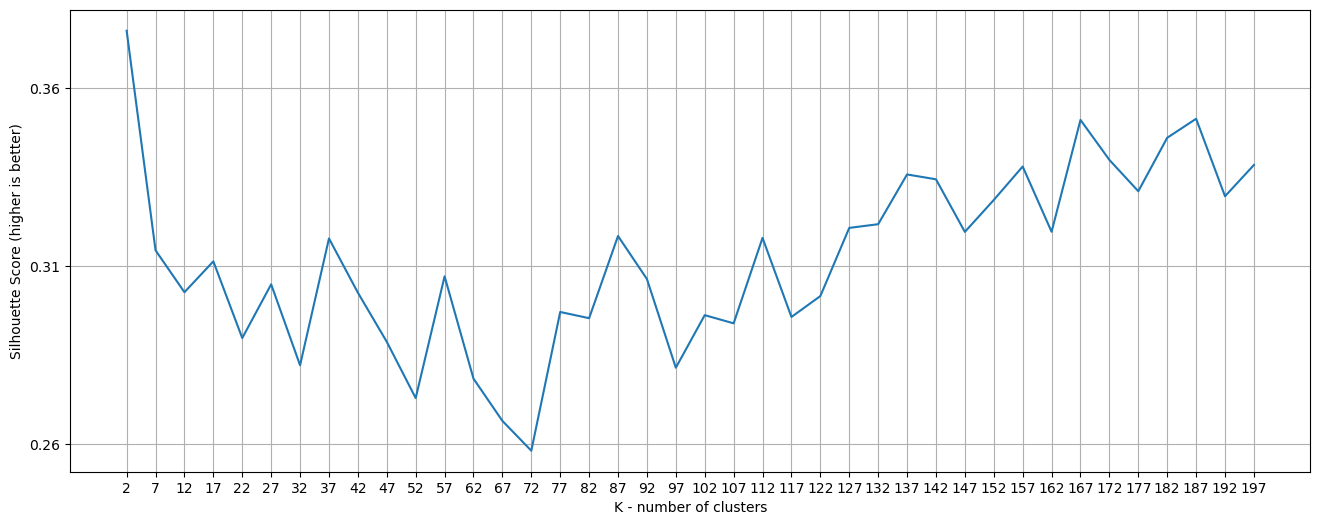

In [19]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.set_xlabel('K - number of clusters')
ax.set_ylabel('Silhouette Score (higher is better)')
ax.plot(numbers_clusters, cluster_scores)

xticks = np.arange(min(numbers_clusters), max(numbers_clusters)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(cluster_scores), 2), max(cluster_scores), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

### Visualização de Cluster
Uma vez escolhido o número ótimo de clusters para o GMM utilizando o método de pontuação acima, poderemos visualizar os clusters criados. Note que, para propósitos de experimentação, é de bom tom que ajuste o número de clusters para o número selecionado.

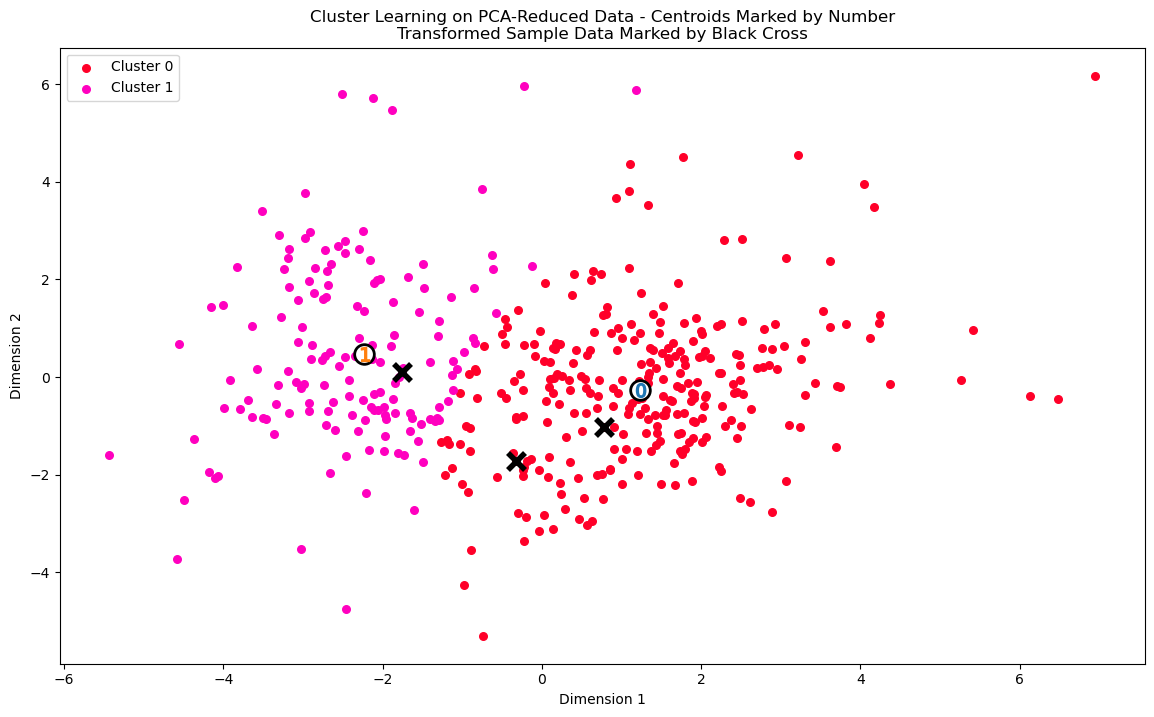

In [20]:
clusterer = GaussianMixture(n_components = 2).fit(reduced_data)
preds = clusterer.predict(reduced_data)
centers = clusterer.means_
sample_preds = clusterer.predict(pca_samples)
vs.cluster_results(reduced_data, preds, centers, pca_samples)

### Recuperação de Dados
Cada cluster apresentado na visualização acima tem um ponto central. Esses centros (ou médias) não são especificamente pontos de dados não específicos dos dados, em vez disso, são *as médias* de todos os pontos estimados em seus respectivos clusters. Para o problema de criar segmentações de clientes, o ponto central do cluster corresponde *a média dos clientes daquele segmento*. Já que os dados foram atualmente reduzidos em dimensões e escalas por um algoritmo, nós podemos recuperar a despesa representativa do cliente desses pontos de dados ao aplicar transformações inversas.

In [21]:
# Transforma inversamento os centros
log_centers = pca.inverse_transform(centers)

# Exponencia os centros
true_centers = np.exp(log_centers)

# Mostra os verdadeiros centros
segments = ['Segmento {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)

# Mostra a descrição do conjunto de dados
display(data.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segmento 0,8962.0,2109.0,2758.0,2065.0,353.0,729.0
Segmento 1,3430.0,7882.0,12312.0,856.0,4756.0,950.0


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


**Segmento 0**: Percebemos que a predominância dos produtos é Fresh(perecíveis) e quantidades abaixo da mediana para o restantes das features. Dessa forma, acredito que é uma quitanda, dessas especializadas em frutas e verduras, mas que não deixam de ter um pouquinho dos demais itens nececssários em uma casa.

**Segmento 1**: De acordo com os valores encontrados, podemos perceber que o estabelecimento movimenta uma grande quantidade de produtos secos/molhados e uma quantidade média de produtos frágeis, em relação a validade. Dessa forma, acredito que se trata de  uma lojinha de frios, dessas especializadas em vender ameixas, amendoins torrados, petiscos, mas que também vendem presunto, queijo e mortadela, que são produtos que precisam ser armazenados refrigerados, isso também explica uma quantidade maior que a mediana para a "Frozen". Nesses tipos de estabelecimentos também é fácil encontrar ovos e outros derivados de leite.

In [22]:
# Mostra as previsões
for i, pred in enumerate(sample_preds):
    print( "Amostra ", i, "prevista no cluster", pred)
    
samples_plot 

Amostra  0 prevista no cluster 1
Amostra  1 prevista no cluster 0
Amostra  2 prevista no cluster 0


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,12669,9656,7561,214,2674,1338
229,8656,2746,2501,6845,694,980
431,8533,5506,5160,13486,1377,1498


Baseado nas características dos cluster análisados no tópico anterior, tentarei explicar abaixo a classificação das amostras coletadas no início dos trabalhos:

**Amostra do índice 0**: Para essa amostra, mesmo com a predominância de Fresh, foi levado em consideração os valores altos para Milk, que ficou acima de 75% dos itens nessa feature, e Grocery que ficou acima de 50%. Dessa forma, como Milk e Grocery possuem maior peso no cluster 1 que Fresh, acredito que a classificação foi correta no cluster 1.

**Amostra do índice 229**: Essa amostra possui valores altos para Fresh e Frozen, bem como valores abaixo da mediana para Milk e Grocery, mas como o centro do cluster 0 possui valores altos para Fresh, acredito que isso seria motivo suficiente para ficarem no cluster 0, onde Fresh possui maior peso. 

**Amostra do índice 431**: Essa amostra é um pouco difícil de classificar, mas como Fresh e Frozen possuem os valores muitos mais altos e Fresh possui um peso maior no cluster 0, acredito que a classificação foi correta.

## Conclusão

Alterar o serviço de entrega sem entender o seguimento de cada cliente, seria a pior mudança a ser feita por uma distribuidora que preze pela qualidade dos seus serviços, porque alguns clientes serão mais afetados que outros. Pensando nisso, agora que sabemos o segmento dos clientes da distribuidora, a realização de [testes A/B](https://en.wikipedia.org/wiki/A/B_testing) é uma boa maneira de realizar esse tipo de mudança. 

Acredito que reduzir o serviço de entrega de 5 dias para 3 dias irá afetar negativamente os clientes do segmento 0, devido a predominância de produtos perecíveis. Estabelecimentos que trabalham com grande quantidade de perecíveis precisam, necessariamente, de produtos mais "vivos" para agradar os consumidores. Por outro lado, os clientes do segmento 1 serão menos afetados por esses 2 dias a menos no serviço de entrega, porque como vimos anteriormente, eles aparentam trabalhar mais com produtos mais duráveis. Dessa forma, acredito que para esse segmento a mudança seria menos impactante. 

Para prever em qual segmento novos clientes estarão, podemos utilizar o próprio modelo que gerou os segmentos atuais, utilizando os clusters como variável alvo.

### Visualizando Distribuições Subjacentes

No começo deste projeto, foi discutido que os atributos `'Channel'` e `'Region'` seriam excluídos do conjunto de dados, então as categorias de produtos do cliente seriam enfatizadas na análise. Ao reintroduzir o atributo `'Channel'` ao conjunto de dados, uma estrutura interessante surge quando consideramos a mesma redução de dimensionalidade da PCA aplicada anteriormente no conjunto de dados original.

A visualização abaixo mostra os pontos de dados que são rotulado como`'HoReCa'` (Hotel/Restaurante/Café) ou `'Retail'`. Além disso, as amostras de pontos circuladas no corpo, que identificará o rótulo.

In [23]:
# Mostra os resultados do clustering baseado nos dados do 'Channel'
vs.channel_results(reduced_data, outliers, pca_samples)

Dataset could not be loaded. Is the file missing?


False

Os resultados do modelo com Gaussian Mixture Model previu corretamente a existência de 2 clusters, assim como o coeficiente de silhueta que deu a maior pontuação para os 2 clusters. Acabei identificando corretamente que no cluster 0 os clientes são do segmento de varejo, já no segmento 1 eu imaginava ser da área do varejo também, mas com um foco um pouco diferente do seguimento 0. Após visualizar os canais definidos pela distribuidora, percebo que faz total sentido a classificação do segmento 1. Outro ponto a se observar é o deslocamento de alguns pontos para cima do cluster vizinho.

## Referências

- https://stackoverflow.com/questions/43545879/bar-chart-with-multiple-labels
- https://stackoverflow.com/questions/47014927/how-to-create-dataframe-for-loops-in-python
- https://stackoverflow.com/questions/23591254/python-pandas-matplotlib-annotating-labels-above-bar-chart-columns
- https://pt.wikipedia.org/wiki/Regress%C3%A3o_linear_simples
- https://stats.stackexchange.com/questions/224722/should-outliers-be-removed-from-principal-components-analysis
- http://stp.lingfil.uu.se/~santinim/ml/2016/Lect_10/10c_UnsupervisedMethods.pdf
- http://playwidtech.blogspot.com/2013/02/k-means-clustering-advantages-and.html
- https://home.deib.polimi.it/matteucc/Clustering/tutorial_html/mixture.html
- http://www.nickgillian.com/wiki/pmwiki.php/GRT/GMMClassifier
